# WeatherPy

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats =['retina']

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime
import time
import pycountry
import seaborn as sns
from scipy.stats import linregress
from matplotlib.pylab import rcParams

sns.set()
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Set the data display options in a float format
pd.options.display.float_format = '{:,.2f}'.format

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print('Number of unique cities', len(cities))

# Creating random dataset for testing
test_cities = np.random.choice(cities, 100)
print('\nRandom array of 100 cities for testing:', [test_cities[i].title() for i in range(len(test_cities))])

Number of unique cities 622

Random array of 100 cities for testing: ['Garowe', 'Tank', 'Clarksburg', 'Vostok', 'Pretoria', 'Tasiilaq', 'Olinda', 'Noyabrsk', 'Ponta Delgada', 'Delhi', 'Humboldt', 'Gat', 'Gat', 'Morant Bay', 'Hobyo', 'Poum', 'Maniitsoq', 'Hudson Bay', 'Damghan', 'Vaini', 'Lebu', 'Puerto Escondido', 'Sibolga', 'Hithadhoo', 'Ipora', 'Rolim De Moura', 'Belaya Gora', 'Kiruna', 'Cicevac', 'Saint George', 'Butaritari', 'Pangody', 'Choix', 'Ekibastuz', 'Ruatoria', 'Mindelo', 'Gornyy', 'Hobyo', 'Bubaque', 'Sept-Iles', 'Rocha', 'Saint-Pierre', 'Gornyy', 'Cabo San Lucas', 'Bargal', 'Lolua', 'Remedios', 'Tsihombe', 'Atlantis', 'Tongliao', 'Guerrero Negro', 'Pesochnoye', 'Walvis Bay', 'Chokurdakh', 'Erzin', 'Ambon', 'Egvekinot', 'Hamilton', 'Palabuhanratu', 'Mildura', 'Nanakuli', 'Slave Lake', 'Jardim', 'Asfi', 'Puerto Escondido', 'Tahoua', 'Turukhansk', 'Portobelo', 'Chhindwara', 'Shchebetovka', 'Arlit', 'Iqaluit', 'Thompson', 'Ekibastuz', 'Gat', 'Torbay', 'Tocache', 'Waingapu', '

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
query_url

'http://api.openweathermap.org/data/2.5/weather?appid=c6f6a86e8a097acc28080af8686cb857&units=metric&q='

In [5]:
# set up lists to hold reponse info
lat = []
lon = []
temp_max = []
humidity = []
cloudiness = []
wind_speed = []
country = []
date = []
found_cities = []
not_found_cities = []

In [6]:
# Loop through the list of cities and perform a request for data on each
print('Beginning data retrieval for ', len(cities), ' cities\n')
for city in cities:
    response = requests.get(query_url + city).json()
#    print ('Processing request for city:', city)
    try:
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp_max.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
        wind_speed.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        found_cities.append(city)
    except:
        not_found_cities.append(city)
        pass
    if len(found_cities) % 40 == 0: 
        print('Processing records: found ', len(found_cities),' cities, skipped ', len(not_found_cities), 'cities')
print('\nData retrieval is over\n')
print('Number of skipped cities = ', len(not_found_cities))
print([not_found_cities[i].title() for i in range(len(not_found_cities))])

Beginning data retrieval for  622  cities

Processing records: found  40  cities, skipped  4 cities
Processing records: found  80  cities, skipped  8 cities
Processing records: found  120  cities, skipped  13 cities
Processing records: found  160  cities, skipped  15 cities
Processing records: found  200  cities, skipped  16 cities
Processing records: found  240  cities, skipped  17 cities
Processing records: found  280  cities, skipped  23 cities
Processing records: found  320  cities, skipped  31 cities
Processing records: found  360  cities, skipped  36 cities
Processing records: found  400  cities, skipped  38 cities
Processing records: found  440  cities, skipped  39 cities
Processing records: found  480  cities, skipped  42 cities
Processing records: found  520  cities, skipped  45 cities
Processing records: found  560  cities, skipped  52 cities

Data retrieval is over

Number of skipped cities =  53
['Barentsburg', 'Mys Shmidta', 'Illoqqortoormiut', 'Amderma', 'Belushya Guba', 

In [7]:
# create a data dict from found_cities, lat, lon, temp_max, humidity, cloudiness, wind_speed, country
weather_dict = {
    "City": found_cities,
    "Lat": lat,
    "Lng": lon,
    "Max_Temp": temp_max,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind_Speed": wind_speed,
    "Country_Code": country
                }

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
def country_flag(df):
    if (len(df['Country_Code'])==2 and df['Country_Code'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['Country_Code']).name
    else:
        return 'Invalid Code'

In [9]:
# create a data frame from data dict
weather_data = pd.DataFrame(weather_dict)
weather_data['City'] = weather_data['City'].map(str.upper)  
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
weather_data['Country_Name'] = weather_data.apply(country_flag, axis = 1)
weather_data['UTC_DateTime']= [datetime.datetime.utcfromtimestamp(date[i]) for i in range(len(date))]
weather_data.head()

,City,Lat,Lng,Max_Temp,Humidity,Cloudiness,Wind_Speed,Country_Code,Country_Name,UTC_DateTime
0,PUNTA ARENAS,-53.15,-70.92,-1.00,92,75,4.10,CL,Chile,2020-07-17 20:34:53
1,KADNIKOV,59.50,40.34,13.08,98,32,3.51,RU,Russian Federation,2020-07-17 20:36:36
2,AVARUA,-21.21,-159.78,22.00,64,16,2.60,CK,Cook Islands,2020-07-17 20:36:37
3,ANCUD,-41.87,-73.82,10.56,100,90,5.70,CL,Chile,2020-07-17 20:36:37
4,SAN PATRICIO,19.22,-104.70,32.00,66,75,5.10,MX,Mexico,2020-07-17 20:36:37


In [10]:
weather_data.count()

City            569
Lat             569
Lng             569
Max_Temp        569
Humidity        569
Cloudiness      569
Wind_Speed      569
Country_Code    569
Country_Name    569
UTC_DateTime    569
dtype: int64

In [11]:
weather_data.describe()

,Lat,Lng,Max_Temp,Humidity,Cloudiness,Wind_Speed
count,569.00,569.00,569.00,569.00,569.00,569.00
mean,20.61,17.47,20.41,70.34,49.61,3.61
std,33.86,91.42,8.22,21.10,38.67,2.47
min,-54.80,-179.17,-2.00,3.00,0.00,0.16
25%,-8.62,-62.06,14.04,60.00,7.00,1.80
50%,25.52,22.02,21.00,76.00,44.00,3.10
75%,50.20,96.37,26.39,87.00,90.00,5.02
max,78.22,178.42,39.44,100.00,100.00,15.05


## Inspect the data and remove the cities where the humidity >= 100%.
----
Skip this step if there are no cities that have humidity >= 100%. 

In [12]:
high_humidity = weather_data[weather_data['Humidity']>=100]
high_humidity

,City,Lat,Lng,Max_Temp,Humidity,Cloudiness,Wind_Speed,Country_Code,Country_Name,UTC_DateTime
3,ANCUD,-41.87,-73.82,10.56,100,90,5.70,CL,Chile,2020-07-17 20:36:37
59,HASAKI,35.73,140.83,19.00,100,75,4.10,JP,Japan,2020-07-17 20:36:44
62,TORBAY,47.67,-52.73,10.56,100,90,8.70,CA,Canada,2020-07-17 20:35:15
85,IQALUIT,63.75,-68.51,11.00,100,90,1.50,CA,Canada,2020-07-17 20:36:50
86,ESPERANCE,-33.87,121.90,8.00,100,90,5.70,AU,Australia,2020-07-17 20:36:50
113,CHRISTCHURCH,-43.53,172.63,6.67,100,100,1.50,NZ,New Zealand,2020-07-17 20:36:54
163,TATEYAMA,34.98,139.87,20.00,100,75,2.60,JP,Japan,2020-07-17 20:33:34
201,KATSUURA,35.13,140.30,20.00,100,75,2.60,JP,Japan,2020-07-17 20:37:05
280,DENPASAR,-8.65,115.22,26.00,100,20,3.10,ID,Indonesia,2020-07-17 20:37:15
314,TILICHIKI,60.47,166.10,10.08,100,100,2.22,RU,Russian Federation,2020-07-17 20:37:19


In [13]:
#  Get the indices of cities that have humidity over 100%.
index_label = weather_data.query('Humidity >=100').index.tolist() 
print(index_label, sep=',')

[3, 59, 62, 85, 86, 113, 163, 201, 280, 314, 317, 403, 406, 408, 471, 479, 487, 490, 515]


In [14]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(index_label, axis=0, inplace=False)
clean_city_data.shape

(550, 10)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [15]:
# Store plot data
lat = clean_city_data['Lat']
tem = clean_city_data['Max_Temp']
hum = clean_city_data['Humidity']
cld = clean_city_data['Cloudiness']
wnd = clean_city_data['Wind_Speed']
plot_date = weather_data['UTC_DateTime'][0].date().strftime("%d %b %Y ")

## Latitude vs. Temperature Plot

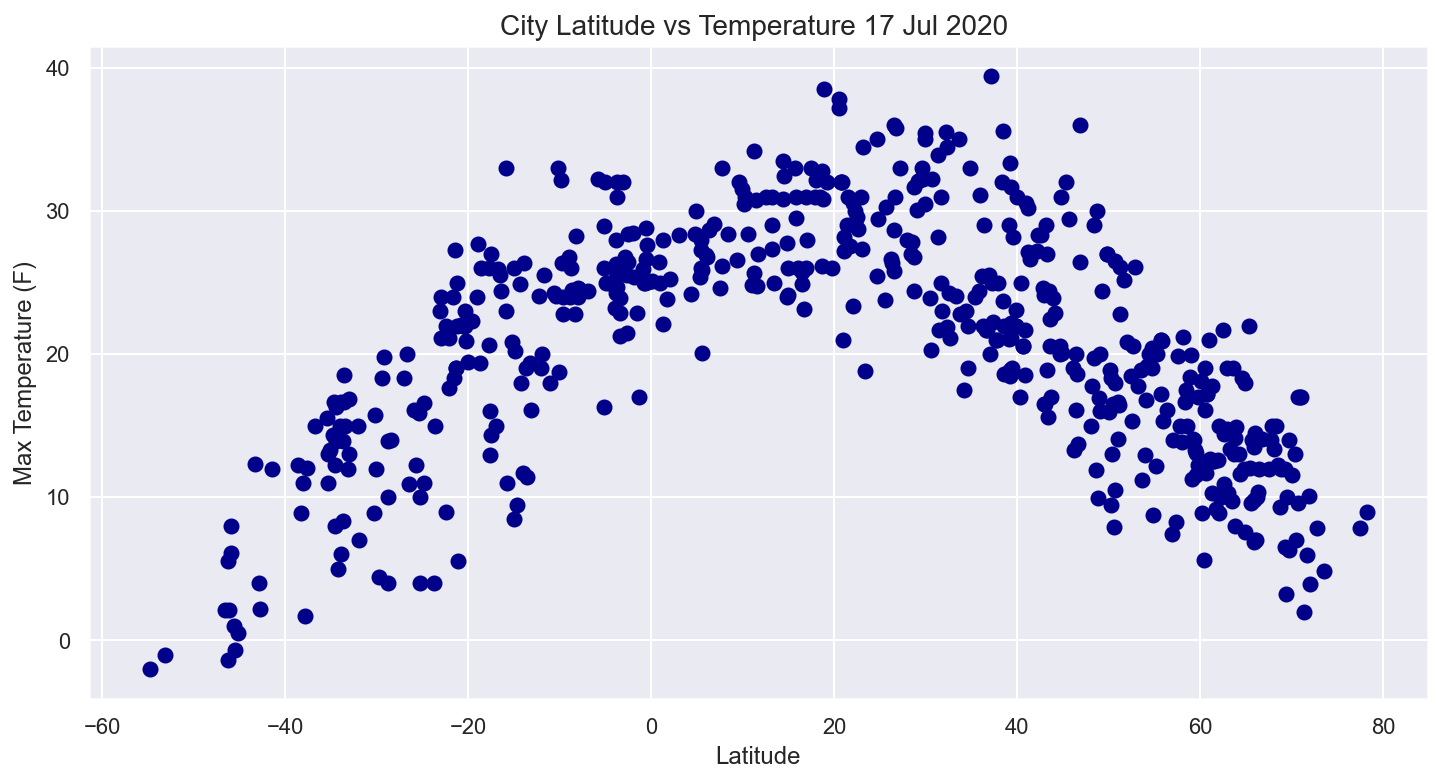

In [16]:
_= plt.plot(lat, tem, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Max Temperature (F)')
_ = plt.title(f'City Latitude vs Temperature {plot_date}', size=14)

## Latitude vs. Humidity Plot

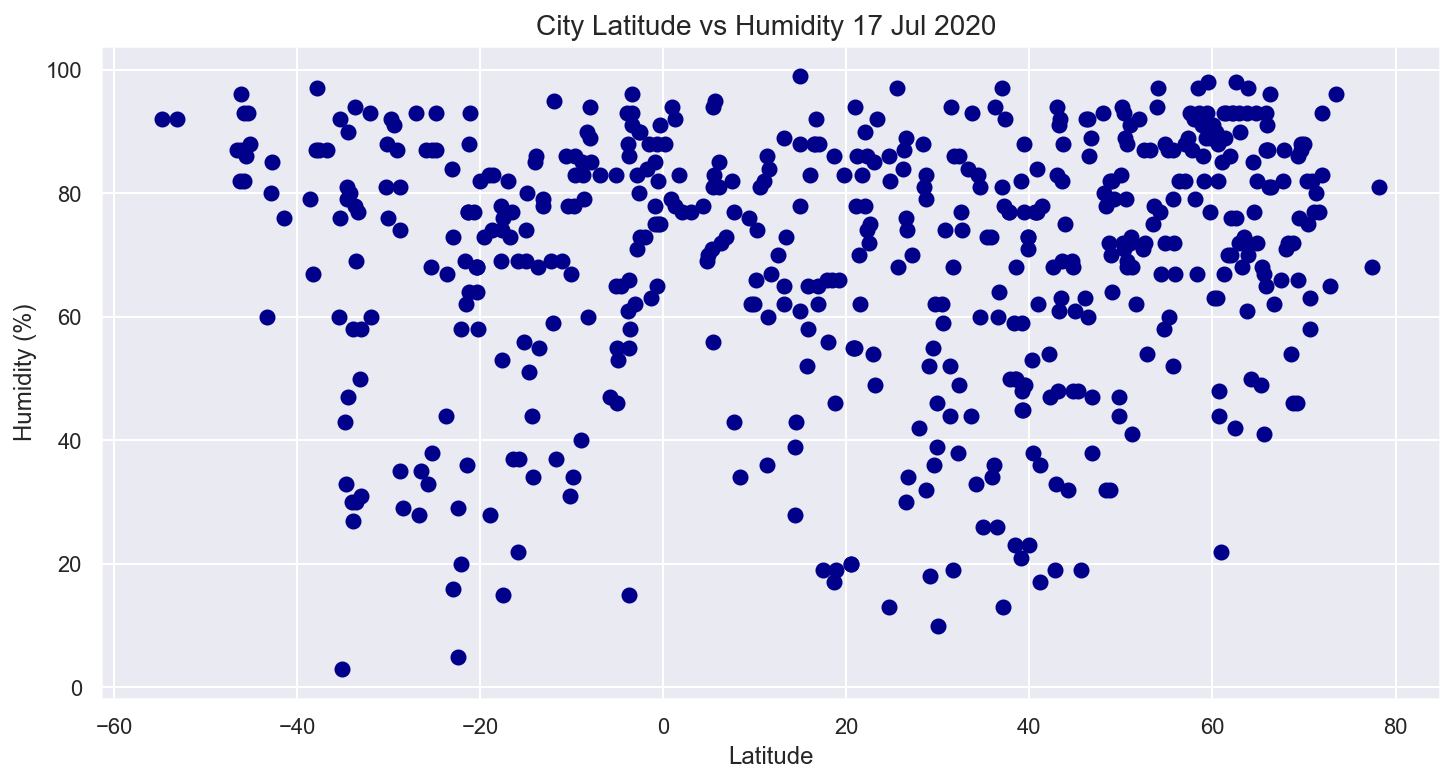

In [17]:
_= plt.plot(lat, hum, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Humidity (%)')
_ = plt.title(f'City Latitude vs Humidity {plot_date}', size=14)

## Latitude vs. Cloudiness Plot

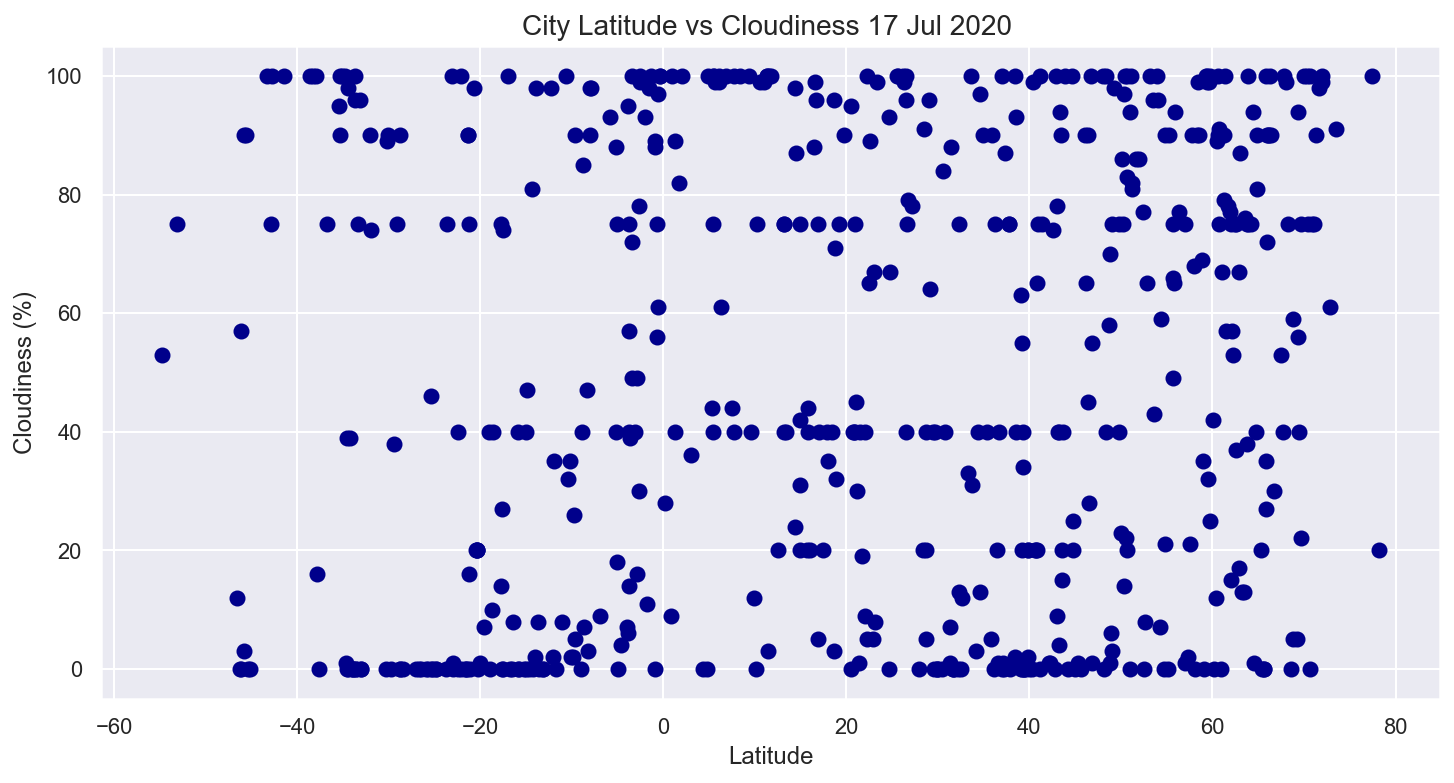

In [18]:
_= plt.plot(lat, cld, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Cloudiness (%)')
_ = plt.title(f'City Latitude vs Cloudiness {plot_date}', size=14)

## Latitude vs. Wind Speed Plot

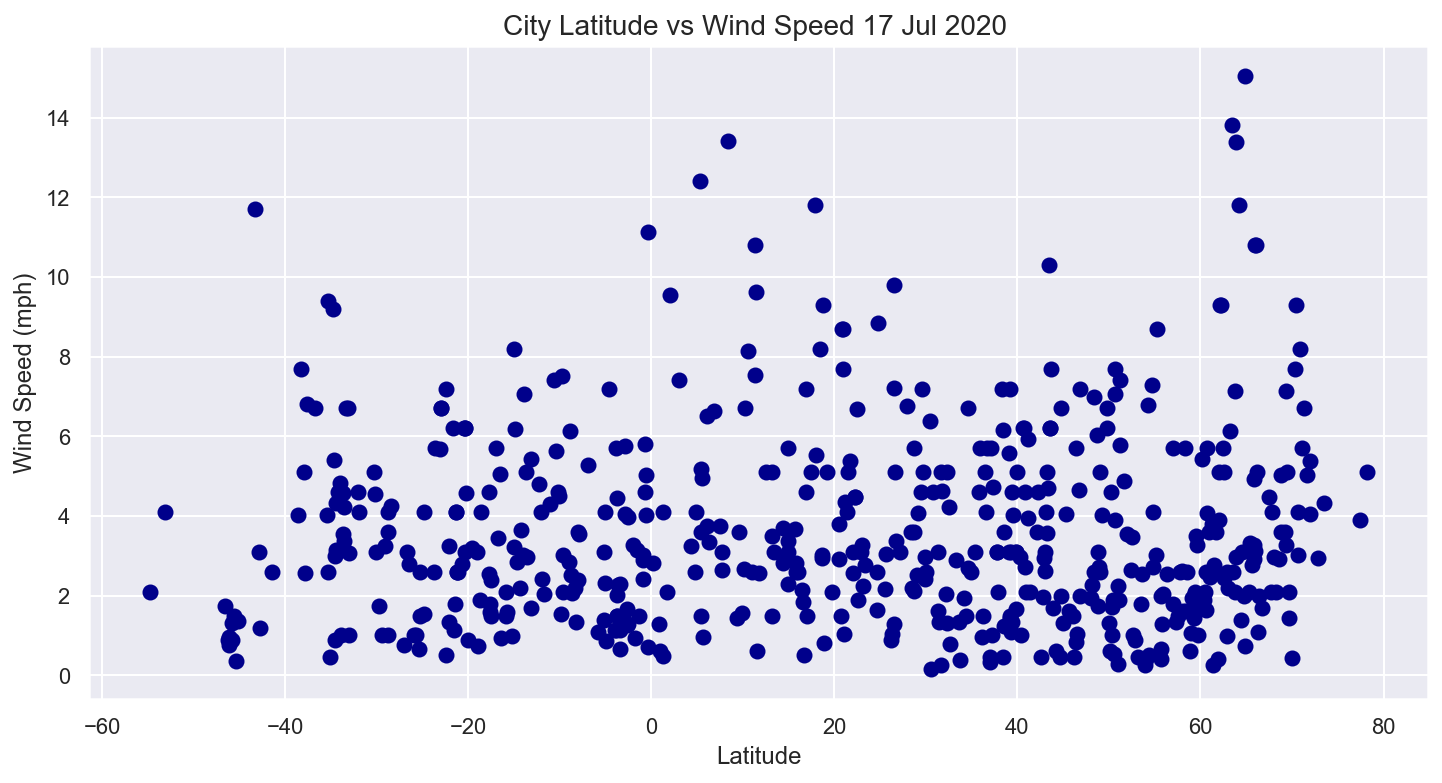

In [19]:
_= plt.plot(lat, wnd, marker='.', markersize=14, color='darkblue', linestyle='none')
_ = plt.xlabel('Latitude')
_ = plt.ylabel('Wind Speed (mph)')
_ = plt.title(f'City Latitude vs Wind Speed {plot_date}', size=14)

## Linear Regression

In [20]:
# OPTIONAL: Create a function to create Linear Regression plots


In [21]:
# Create Northern and Southern Hemisphere DataFrames
clean_city_data['Hemisphere'] = (
        np.select(
        condlist=[clean_city_data['Lat'] >= 0, clean_city_data['Lat'] < 0], 
        choicelist=['Northern', 'Southern'] 
       ))
clean_city_data['Hemisphere']= clean_city_data['Hemisphere'].astype('category')
clean_city_data.head()

,City,Lat,Lng,Max_Temp,Humidity,Cloudiness,Wind_Speed,Country_Code,Country_Name,UTC_DateTime,Hemisphere
0,PUNTA ARENAS,-53.15,-70.92,-1.00,92,75,4.10,CL,Chile,2020-07-17 20:34:53,Southern
1,KADNIKOV,59.50,40.34,13.08,98,32,3.51,RU,Russian Federation,2020-07-17 20:36:36,Northern
2,AVARUA,-21.21,-159.78,22.00,64,16,2.60,CK,Cook Islands,2020-07-17 20:36:37,Southern
4,SAN PATRICIO,19.22,-104.70,32.00,66,75,5.10,MX,Mexico,2020-07-17 20:36:37,Northern
5,JAMESTOWN,42.10,-79.24,27.22,54,1,3.60,US,United States,2020-07-17 20:36:37,Northern


In [22]:
# Export the City_Data into a csv
clean_city_data.to_csv(output_data_file, index=False) 

                        Data exploration (Northern vs Southern Hemisphere)


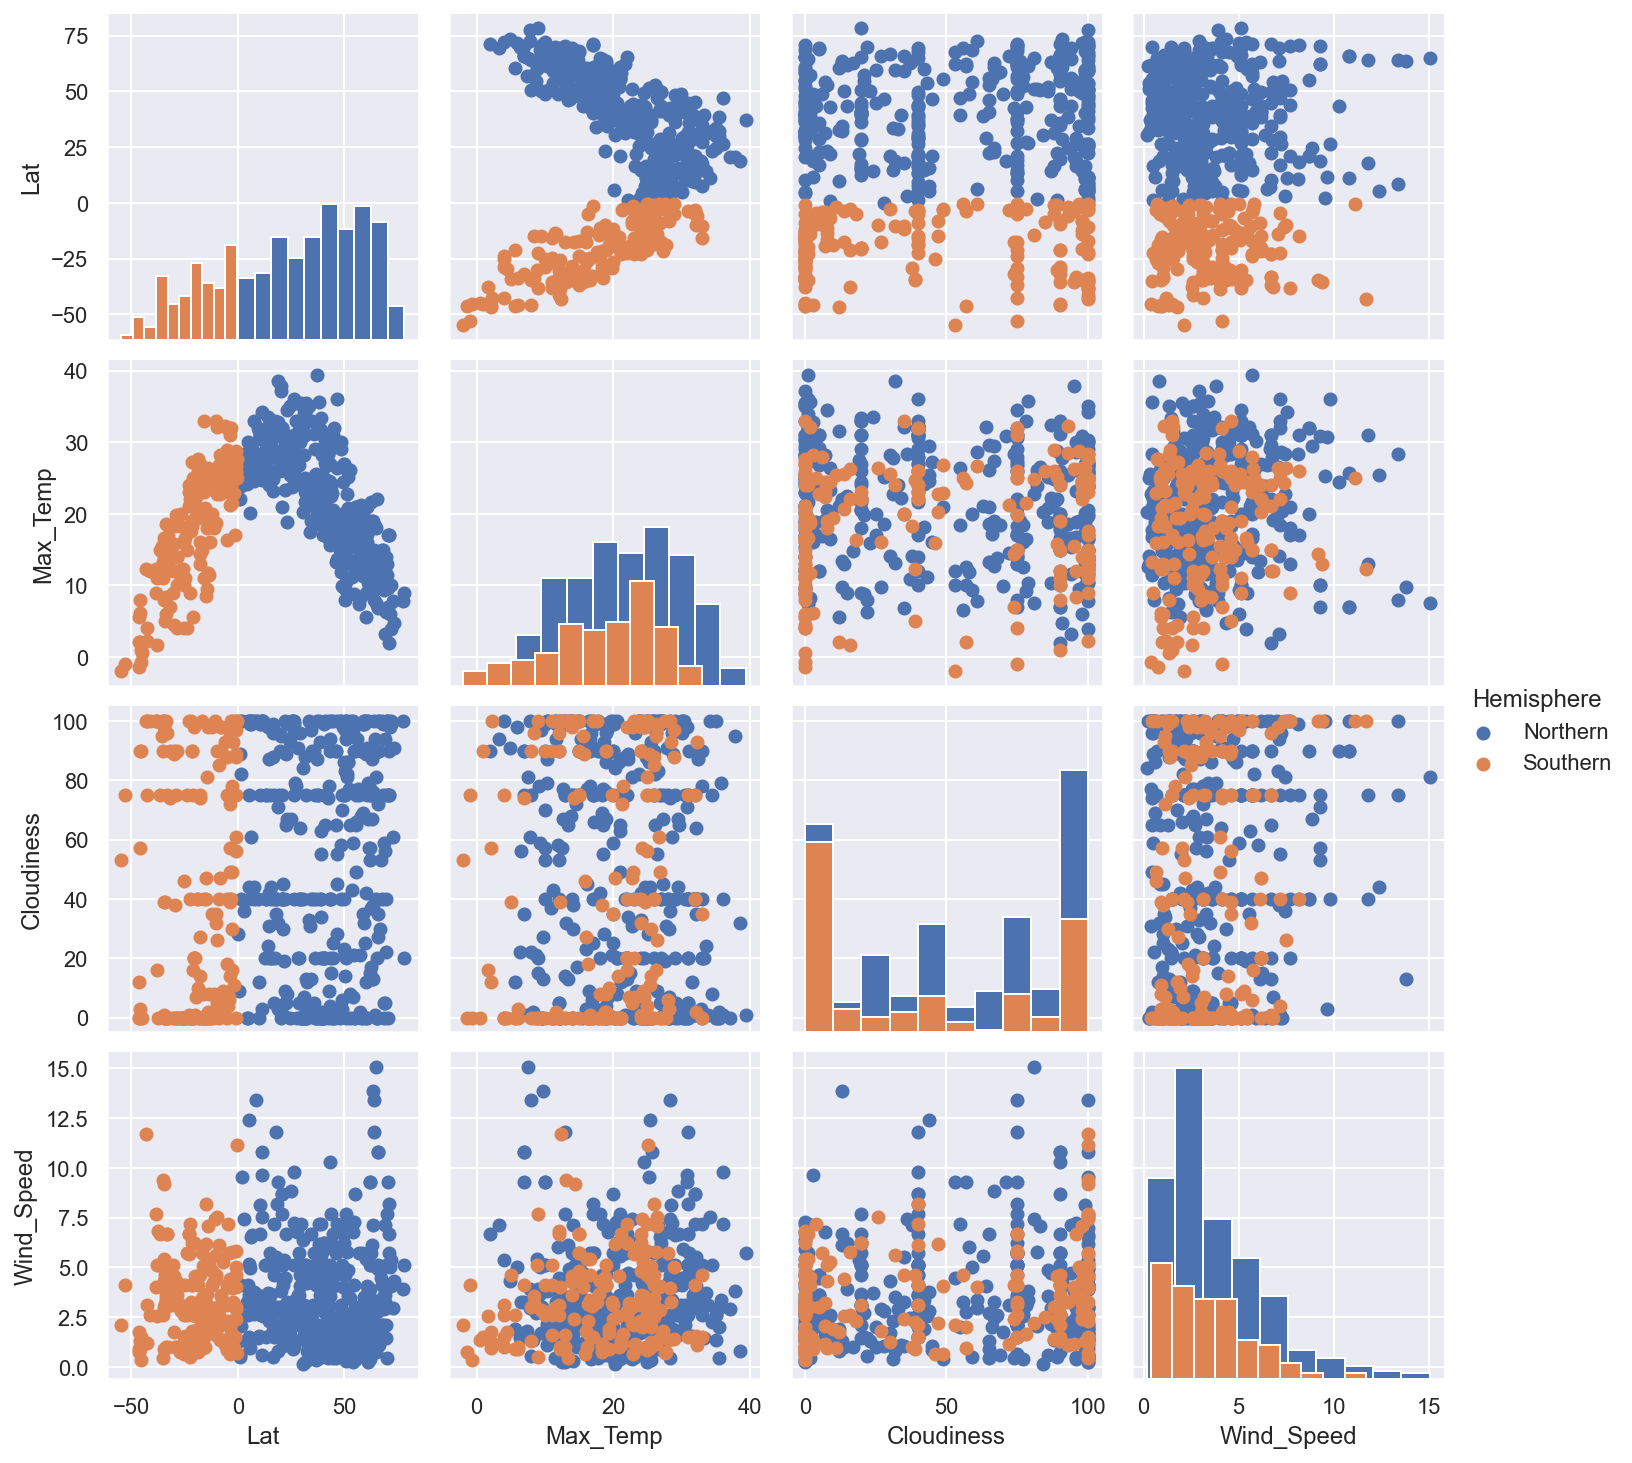

In [23]:
# Data Exploration
explore_data = clean_city_data.filter(['Lat', 'Max_Temp', 'Cloudiness', 'Wind_Speed', 'Hemisphere'])
g=sns.PairGrid(explore_data, hue='Hemisphere')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
print(' '*23,'Data exploration (Northern vs Southern Hemisphere)')

In [24]:
# Extract and Store Data for Regression Analysis
north_data = clean_city_data[clean_city_data['Hemisphere']=='Northern']
south_data = clean_city_data[clean_city_data['Hemisphere']=='Southern']

In [25]:
# Create Class DataAnalysis
class DataAnalysis():
    regress_values = None
    line_eq = None
  
    # Define initialization method
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    # Define linear regression method
    def lin_regr(self):
        (slope, intercept, rvalue, pvalue, stderr) = linregress(self.x, self.y)
        self.rsq_value = round(rvalue**2, 4)
        self.regress_values = self.x * slope + intercept
        self.line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        return self.regress_values, self.line_eq, self.rsq_value
    
    # Define scatter plot method
    def scat_plot(self):
        regress_values, line_eq, rsq_value = self.lin_regr()
        x_axes = np.median(self.x)
        y_axes = np.median(self.y)-20
        plt.scatter(self.x, self.y)
        plt.plot(self.x, regress_values, "r-")
        plt.annotate(line_eq, (x_axes, y_axes), fontsize=15,color="red")
        plt.title(f'{self.x.name} vs Latitude {plot_date} R-squared is: {rsq_value}', size=14)
        plt.xlabel(self.x.name)
        plt.ylabel('Latitude')

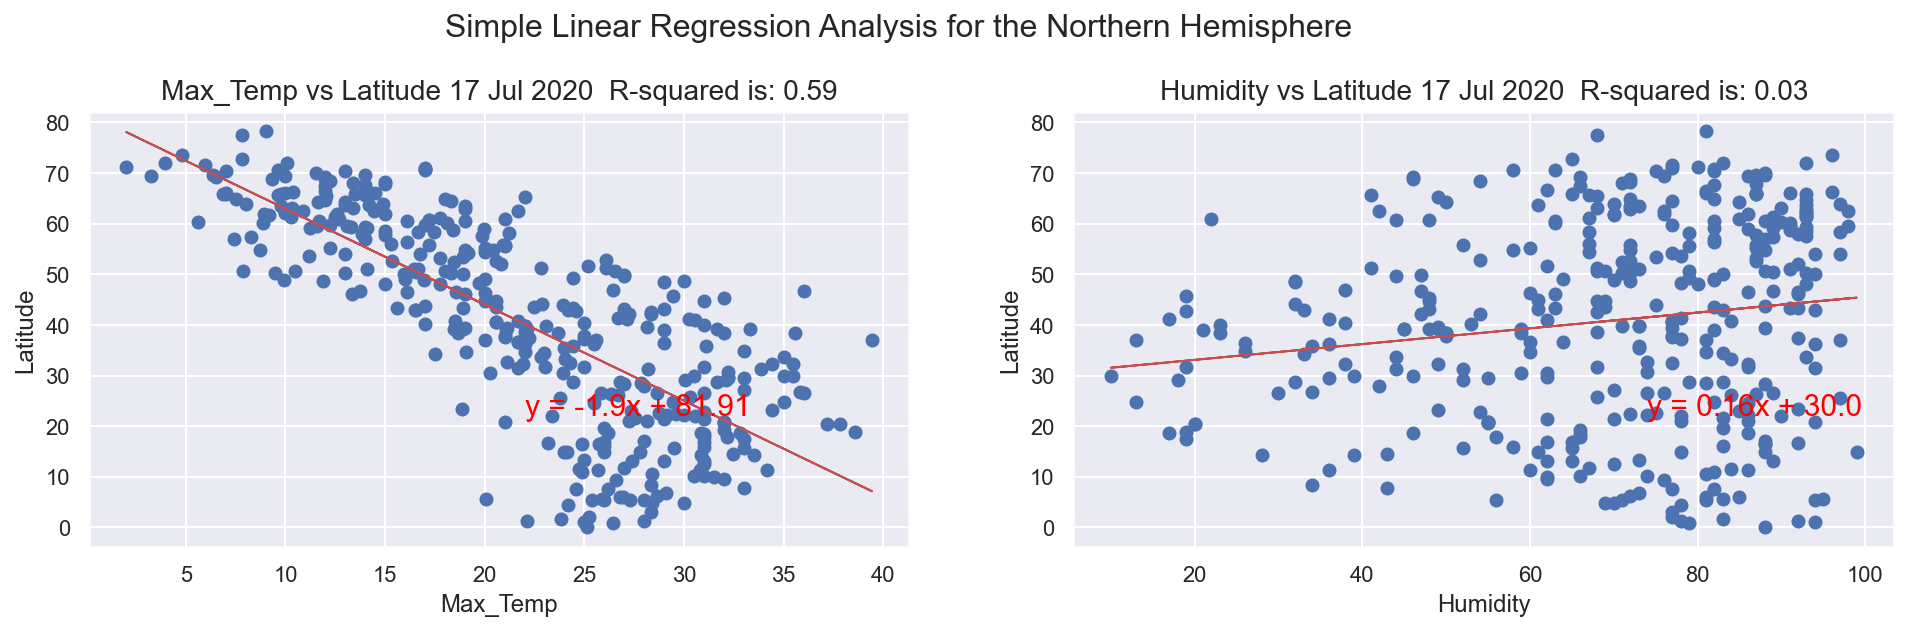

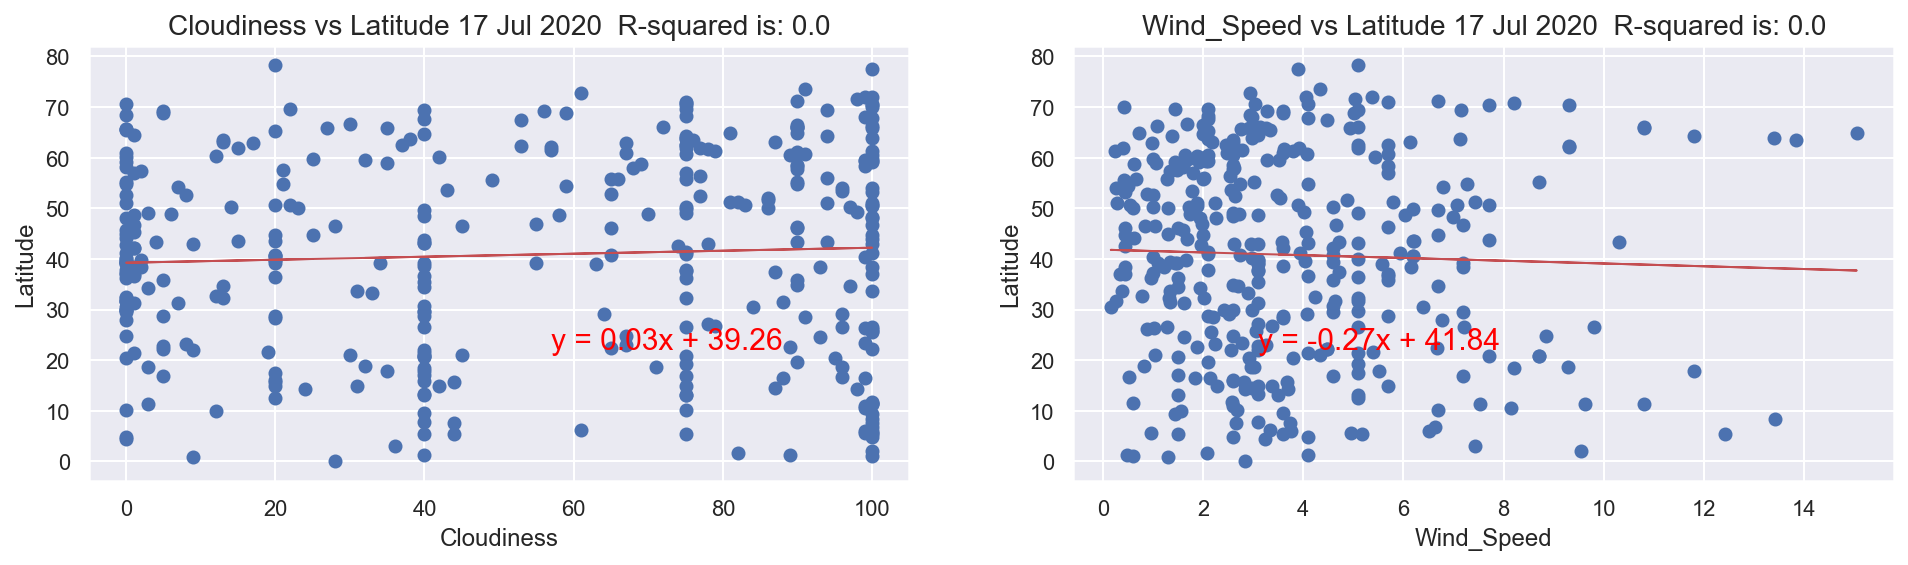

In [26]:
# Regression Analysiss for the Northern Hemisphere
north_temp = DataAnalysis(north_data['Max_Temp'], north_data['Lat'])
north_hum = DataAnalysis(north_data['Humidity'], north_data['Lat'])
north_cld = DataAnalysis(north_data['Cloudiness'], north_data['Lat'])
north_wnd = DataAnalysis(north_data['Wind_Speed'], north_data['Lat'])
# using the variable axs for multiple Axes
plt.figure(figsize=(25, 4))
plt.subplot(131)
plt.suptitle('Simple Linear Regression Analysis for the Northern Hemisphere', x= 0.35, y=1.05, size=16)
north_temp.scat_plot()
plt.subplot(132)
north_hum.scat_plot()
plt.figure(figsize=(25, 4))
plt.subplot(131)
north_cld.scat_plot()
plt.subplot(132)
north_wnd.scat_plot()

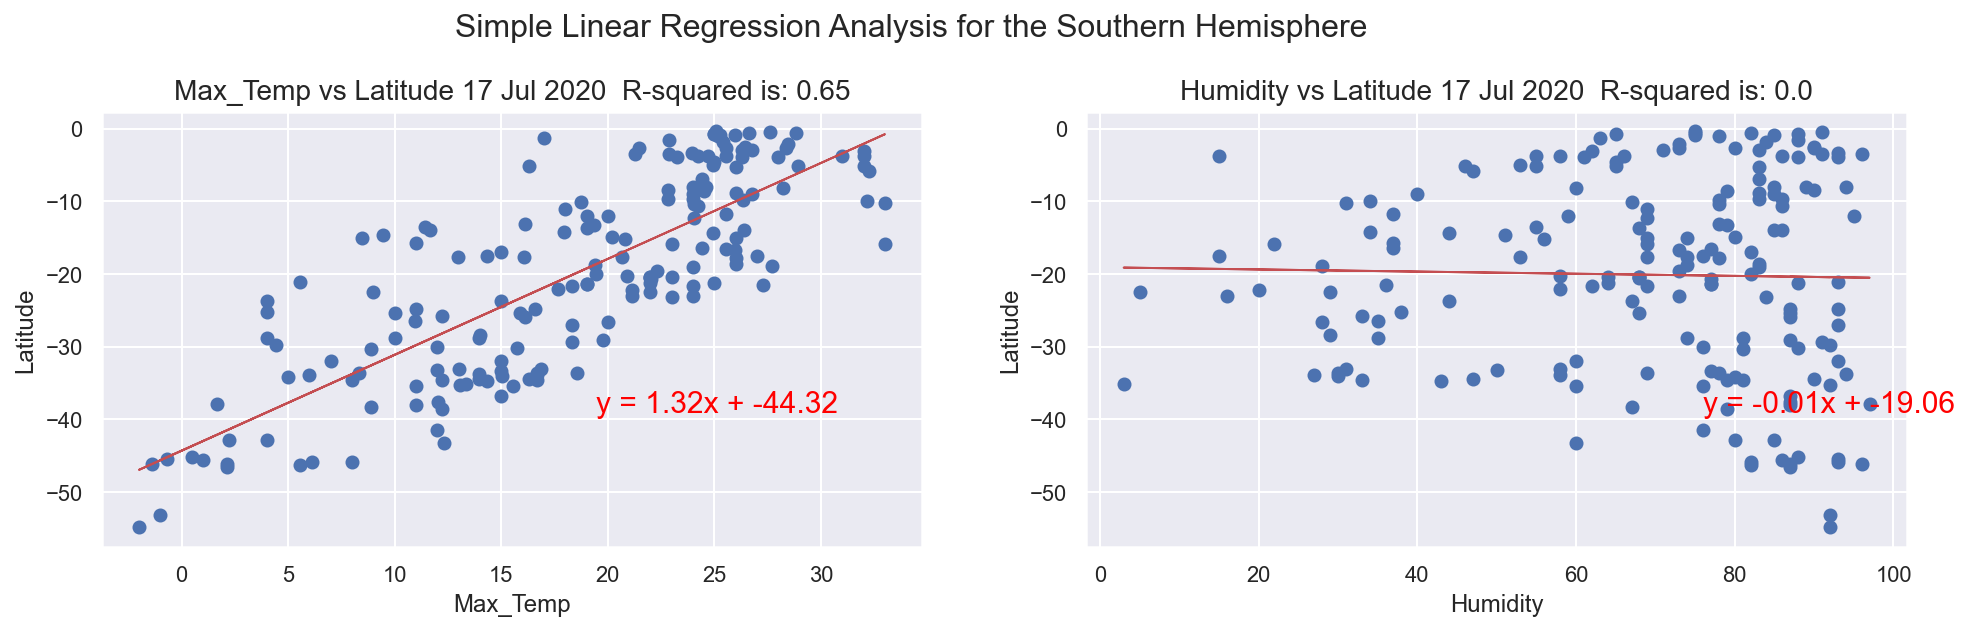

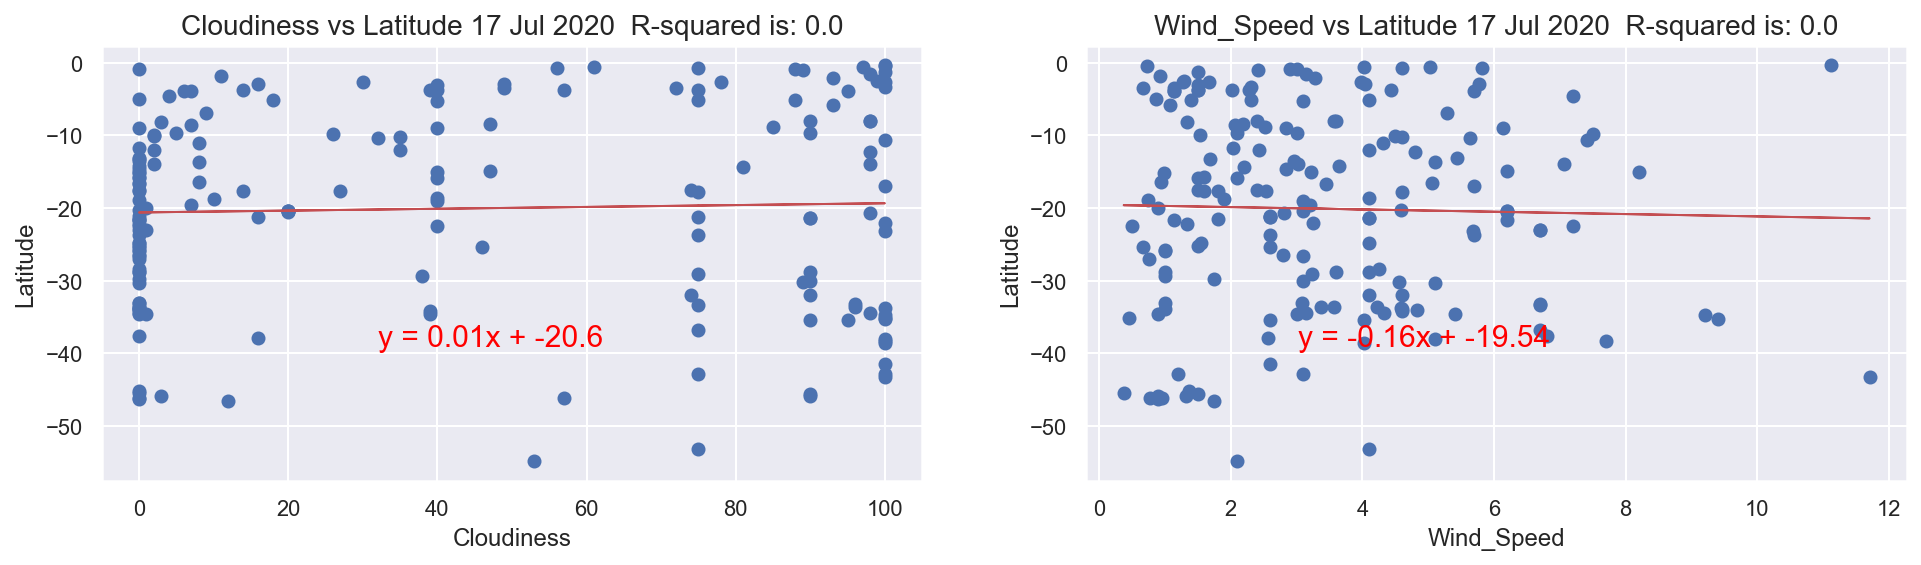

In [27]:
# Regression Analysiss for the Southern Hemisphere
south_temp = DataAnalysis(south_data['Max_Temp'], south_data['Lat'])
south_hum = DataAnalysis(south_data['Humidity'], south_data['Lat'])
south_cld = DataAnalysis(south_data['Cloudiness'], south_data['Lat'])
south_wnd = DataAnalysis(south_data['Wind_Speed'], south_data['Lat'])
# using the variable axs for multiple Axes
plt.figure(figsize=(25, 4))
plt.subplot(131)
plt.suptitle('Simple Linear Regression Analysis for the Southern Hemisphere', x= 0.35, y=1.05, size=16)
south_temp.scat_plot()
plt.subplot(132)
south_hum.scat_plot()
plt.figure(figsize=(25, 4))
plt.subplot(131)
south_cld.scat_plot()
plt.subplot(132)
south_wnd.scat_plot()